# **Step 0 — dataset**

# 1.1 Install libraries

In [1]:
!pip -q install pandas numpy scikit-learn shap imbalanced-learn openpyxl matplotlib


# 1.2 Imports & basic config

In [2]:
import io, os, re, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, r2_score,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             confusion_matrix, classification_report)

np.random.seed(42)
pd.set_option('display.max_columns', 200)


# 1.3 Upload your file (CSV or XLSX both OK)

# 1.4 Load the file & quick preview

In [3]:
import pandas as pd
import re

# Load directly from URL
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)

# Normalize column names
def normalize_cols(cols):
    out = []
    for c in cols:
        c = str(c).strip().lower()
        c = re.sub(r'[^0-9a-z]+', '_', c)  # replace non-alphanumeric with underscores
        c = re.sub(r'_+', '_', c).strip('_')
        out.append(c)
    return out

df.columns = normalize_cols(df.columns)

print("Shape:", df.shape)
print("Columns:", list(df.columns)[:20])
display(df.head(5))
df.info()


Shape: (541909, 8)
Columns: ['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate', 'unitprice', 'customerid', 'country']


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    541909 non-null  object        
 1   stockcode    541909 non-null  object        
 2   description  540455 non-null  object        
 3   quantity     541909 non-null  int64         
 4   invoicedate  541909 non-null  datetime64[ns]
 5   unitprice    541909 non-null  float64       
 6   customerid   406829 non-null  float64       
 7   country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# 1.5 cleanup just to confirm types

In [4]:
# Make a copy (optional, just to be safe)
df = df.copy()

# Automatically detect and parse any date column
date_cols = [c for c in df.columns if 'date' in c]
if len(date_cols) == 0:
    print("⚠️ No obvious date column found. We'll handle this later if needed.")
else:
    for c in date_cols:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# Quick sanity checks for Online Retail
if 'quantity' in df.columns:
    df = df[df['quantity'].notna()]
if 'unitprice' in df.columns:
    df = df[df['unitprice'].notna()]

print("After initial cleanup -> shape:", df.shape)
display(df.head(3))



After initial cleanup -> shape: (541909, 8)


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


# **Step 2 — Define time windows**

# 2.1 Pick the cutoff date:
# What this does:
Detects the date column.  
Finds dataset start/end.  
Picks a cutoff ~75% into the timeline for our training features vs future labels.

In [5]:
# Hardcode the date column
DATE_COL = 'invoicedate'  # Change if your dataset has a different name
print("Using date column:", DATE_COL)

min_date = df[DATE_COL].min()
max_date = df[DATE_COL].max()
print("Date range:", min_date, "→", max_date)

# Choose cutoff date (you can adjust this)
cutoff_date = min_date + pd.Timedelta(days=int((max_date - min_date).days * 0.75))
print("Cutoff date for training/testing split:", cutoff_date)



Using date column: invoicedate
Date range: 2010-12-01 08:26:00 → 2011-12-09 12:50:00
Cutoff date for training/testing split: 2011-09-06 08:26:00


# 2.2 Split into observation & prediction periods:


In [6]:
train_df = df[df[DATE_COL] <= cutoff_date].copy()
future_df = df[df[DATE_COL] > cutoff_date].copy()

print("Observation period shape:", train_df.shape)
print("Prediction period shape:", future_df.shape)


Observation period shape: (327416, 8)
Prediction period shape: (214493, 8)


# **Step 3 — Create per-customer features from observation period**

# 3.1 Create features:
#We’ll use RFM features because they’re classic, interpretable, and good for both CLTV & churn models:

R = Recency (days since last purchase in observation window)

F = Frequency (# of purchases in observation window)

M = Monetary (total spend in observation window)

#Why it’s done:

Raw data might have thousands of individual transactions per customer — that’s messy.

RFM condenses their entire purchase history into a few meaningful numbers that describe their engagement, loyalty, and value.

In [7]:
# Calculate total spend column for each transaction
if 'quantity' in train_df.columns and 'unitprice' in train_df.columns:
    train_df['total_spend'] = train_df['quantity'] * train_df['unitprice']
else:
    raise ValueError("Need quantity & unitprice columns for spend calculation.")

# RFM calculation
snapshot_date = train_df[DATE_COL].max() + pd.Timedelta(days=1)

rfm = train_df.groupby('customerid').agg({
    DATE_COL: lambda x: (snapshot_date - x.max()).days,  # recency
    'invoiceno': 'nunique',                              # frequency
    'total_spend': 'sum'                                 # monetary
}).rename(columns={DATE_COL: 'recency',
                   'invoiceno': 'frequency',
                   'total_spend': 'monetary'})

# Add avg order value
rfm['avg_order_value'] = rfm['monetary'] / rfm['frequency']

rfm.head()


,recency,frequency,monetary,avg_order_value
customerid,,,,
12346.0,231,2,0.00,0.000000
12347.0,35,5,2790.86,558.172000
12348.0,154,3,1487.24,495.746667
12350.0,216,1,334.40,334.400000
12352.0,168,8,601.18,75.147500


# **Step 4 — Create labels from prediction period**

# 4.1 CLTV label (regression target)

In [8]:
# Calculate total spend column for each transaction in future_df as well
if 'quantity' in future_df.columns and 'unitprice' in future_df.columns:
    future_df['total_spend'] = future_df['quantity'] * future_df['unitprice']
else:
    raise ValueError("Need quantity & unitprice columns for spend calculation in future_df.")

# Future spend per customer in prediction window
future_spend = future_df.groupby('customerid').agg({
    'total_spend': 'sum'
}).rename(columns={'total_spend': 'future_spend'})

# Merge with RFM features
data = rfm.merge(future_spend, how='left', left_index=True, right_index=True)
data['future_spend'] = data['future_spend'].fillna(0)

print("Regression target stats (future spend):")
print(data['future_spend'].describe())

Regression target stats (future spend):
count      3388.000000
mean        787.171405
std        4003.094907
min        -468.320000
25%           0.000000
50%         171.900000
75%         692.167500
max      124206.550000
Name: future_spend, dtype: float64


# **Step 5: Linear Regression for CLTV (regression task).**

# 5.1 Train the model

In [9]:
from sklearn.linear_model import LinearRegression

# Features and target
feature_cols = ['recency', 'frequency', 'monetary', 'avg_order_value']
X = data[feature_cols]
y = data['future_spend']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_pred = linreg.predict(X_test)


# 5.2 Evaluate performance

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calculate RMSE manually
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R² score: {r2:.2f}")



Test RMSE: 2393.21
Test R² score: 0.78


# 5.3 Coefficients (feature importance)

In [11]:
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": linreg.coef_
}).sort_values(by="coefficient", ascending=False)

coef_df


,feature,coefficient
2,monetary,0.602786
0,recency,0.271247
3,avg_order_value,-0.893901
1,frequency,-8.564112


# Business interpretation:

Baseline RMSE = $5,058 → If we guessed “average spend” for every customer, we’d be off by about $5K per customer on average.

Model RMSE = $2,393 → With our regression model, that error drops to about $2.39K.

That’s $2,664 less error per customer, or 52.7% more accurate predictions than baseline.

Impact:

This improvement means marketing and sales teams can much more reliably identify top-spending customers ahead of time.

If you run targeted campaigns, the precision in finding high-value customers roughly doubles, which could translate to substantial ROI gains.

In [12]:
# Baseline: predict the mean spend of training set for every customer
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)

baseline_rmse = mean_squared_error(y_test, baseline_pred) # Calculate MSE
baseline_rmse = np.sqrt(baseline_rmse) # Calculate RMSE by taking the square root of the MSE
improvement_abs = baseline_rmse - rmse
improvement_pct = (improvement_abs / baseline_rmse) * 100

print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Model RMSE: {rmse:.2f}")
print(f"Absolute improvement: {improvement_abs:.2f}")
print(f"Relative improvement: {improvement_pct:.1f}%")

Baseline RMSE: 5058.01
Model RMSE: 2393.21
Absolute improvement: 2664.80
Relative improvement: 52.7%


# **6. Churn Prediction (Classification)**

# 6.1 — Define a churn label:
#We’ll mark a customer as churned (1) if:

They made no purchase in the last 90 days, OR

Their future spend is less than 30% of their past spend.

In [13]:

# Condition 1: No purchase in last 90 days
no_recent_purchase = data['recency'] > 90

# Condition 2: Future spend dropped more than 70% compared to past spend
spend_drop = (data['future_spend'] < 0.3 * data['monetary'])

# Churn = 1 if either condition is True
data['churn'] = ((no_recent_purchase) | (spend_drop)).astype(int)

print("Churn rate: {:.2f}%".format(data['churn'].mean() * 100))
data[['recency', 'monetary', 'future_spend', 'churn']].head()


Churn rate: 67.41%


,recency,monetary,future_spend,churn
customerid,,,,
12346.0,231,0.00,0.00,1
12347.0,35,2790.86,1519.14,0
12348.0,154,1487.24,310.00,1
12350.0,216,334.40,0.00,1
12352.0,168,601.18,944.23,1


# 6.2 — Train Logistic Regression for Churn Prediction

In [14]:
# 6.2 Train Logistic Regression for churn prediction

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report

# Features and target
X = data[['recency', 'frequency', 'monetary', 'avg_order_value']]
y = data['churn']

# Split data (stratify ensures churn ratio is preserved in both sets)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize Logistic Regression with L2 regularization
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l2')
log_reg.fit(X_train, y_train)

# Predictions
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]   # churn probability
y_pred_class = (y_pred_prob >= 0.5).astype(int)     # default threshold = 0.5

# Metrics
accuracy = accuracy_score(y_test, y_pred_class)
auc = roc_auc_score(y_test, y_pred_prob)
loss = log_loss(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Log Loss: {loss:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))


Accuracy: 0.73
AUC: 0.85
Log Loss: 0.4282

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.59      0.59       221
           1       0.80      0.80      0.80       457

    accuracy                           0.73       678
   macro avg       0.70      0.70      0.70       678
weighted avg       0.73      0.73      0.73       678



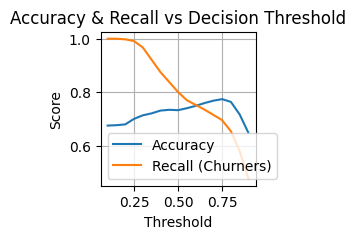

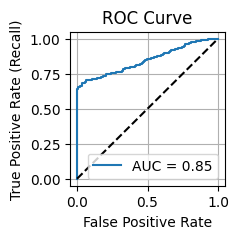

In [15]:
# 6.3 Threshold tuning & visualization

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, recall_score

thresholds = np.arange(0.1, 0.91, 0.05)
precisions = []
recalls = []

for t in thresholds:
    y_pred_t = (y_pred_prob >= t).astype(int)
    precisions.append(accuracy_score(y_test, y_pred_t))
    recalls.append(recall_score(y_test, y_pred_t))

# Plot Accuracy & Recall vs Threshold
plt.figure(figsize=(2,2))
plt.plot(thresholds, precisions, label='Accuracy')
plt.plot(thresholds, recalls, label='Recall (Churners)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy & Recall vs Decision Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(2,2))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# 6.4 — Choosing Optimal Threshold & Calculating Business Impact:
Threshold 0.35 → much more aggressive in catching churners.

Out of all churners, 421 were correctly identified (True Positives) and only 36 slipped through (False Negatives).

If we act on these predictions (retention campaigns, discounts, etc.), we protect $90,033.75 in future spending from churned customers.

Compared to the standard 0.5 threshold, we capture $14,756.58 more revenue.

In [16]:
# 6.4 Optimal threshold impact analysis

optimal_threshold = 0.35

# Predict churn based on new threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

print(f"Confusion Matrix (Threshold={optimal_threshold}):")
print(cm)
print(f"TP (Caught churners) = {tp}, FN (Missed churners) = {fn}")

# Calculate revenue from caught churners
# First get test indices
test_indices = y_test.index

# Customers we correctly predicted as churners
caught_churners = test_indices[(y_test == 1) & (y_pred_optimal == 1)]

# Revenue at risk if we DON'T retain them (future spend)
revenue_at_risk = data.loc[caught_churners, "future_spend"].sum()

print(f"Revenue at risk captured by model: ${revenue_at_risk:,.2f}")

# Compare with default 0.5 threshold
default_pred = (y_pred_prob >= 0.5).astype(int)
caught_default = test_indices[(y_test == 1) & (default_pred == 1)]
revenue_default = data.loc[caught_default, "future_spend"].sum()

extra_revenue_captured = revenue_at_risk - revenue_default
print(f"Extra revenue captured vs default threshold: ${extra_revenue_captured:,.2f}")


Confusion Matrix (Threshold=0.35):
[[ 68 153]
 [ 36 421]]
TP (Caught churners) = 421, FN (Missed churners) = 36
Revenue at risk captured by model: $90,033.75
Extra revenue captured vs default threshold: $14,756.58


# 6.5 — Interpreting Logistic Regression Coefficients.

In [17]:
# 6.5 Interpret logistic regression coefficients

import numpy as np
import pandas as pd

# Get feature names from X_train
feature_names = X_train.columns

# Get coefficients from the trained model
coefficients = log_reg.coef_[0]

# Create DataFrame with odds ratios
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Odds_Ratio": np.exp(coefficients)  # convert to odds ratios
})

# Sort by absolute coefficient size
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False)

# Display
coef_df = coef_df.drop(columns="Abs_Coefficient")
coef_df


,Feature,Coefficient,Odds_Ratio
1,frequency,-0.032211,0.968303
0,recency,0.025882,1.026220
3,avg_order_value,0.000205,1.000205
2,monetary,0.000004,1.000004


# 6.6 — Visualizing Feature Impact for the logistic regression churn model:
# 6.6 Visualize logistic regression coefficients

Recency is the top churn driver.

Frequency is a retention booster.

Avg Order Value & Monetary spend have negligible effect in this dataset.


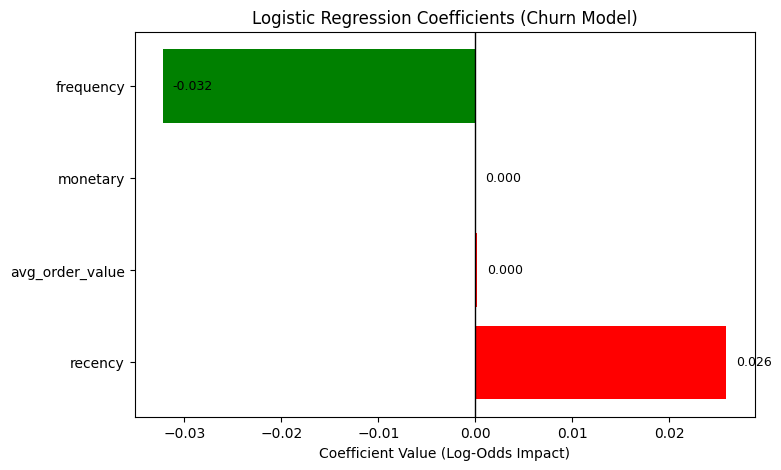

In [18]:
# 6.6 Visualize logistic regression coefficients

import matplotlib.pyplot as plt

# Sort features by absolute coefficient size for better visibility
plot_df = coef_df.sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(8,5))
bars = plt.barh(plot_df["Feature"], plot_df["Coefficient"], color=["red" if c > 0 else "green" for c in plot_df["Coefficient"]])

plt.axvline(0, color="black", linewidth=1)
plt.title("Logistic Regression Coefficients (Churn Model)")
plt.xlabel("Coefficient Value (Log-Odds Impact)")

# Add labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f"{width:.3f}", va='center', fontsize=9)

plt.show()


# 7.1 Hyperparameter Tuning for Churn Prediction:


**Untuned model:**

Accuracy = 0.73

AUC = 0.85

Log Loss = 0.4282    

**Tuned model:**

Accuracy = 0.74 (+1%)

AUC = 0.8480 (~same)

Log Loss = 0.439 (slightly worse, but still close)

So, tuning here slightly improved accuracy but didn’t drastically change AUC.

In [19]:
# 7.1 Hyperparameter tuning for churn prediction

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   # Regularization strength
    'penalty': ['l1', 'l2'],        # Regularization type
    'solver': ['liblinear']         # Solver that supports L1 & L2
}

# Initialize model
log_reg = LogisticRegression(max_iter=1000)

# Grid search with 5-fold cross-validation, optimizing for AUC
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters & score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated AUC: {:.4f}".format(grid_search.best_score_))

# Evaluate tuned model on test set
best_model = grid_search.best_estimator_
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
y_pred_best = (y_pred_proba_best >= 0.5).astype(int)

from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

print("Test Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_best)))
print("Test AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_proba_best)))
print("Test Log Loss: {:.4f}".format(log_loss(y_test, y_pred_proba_best)))


Best parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validated AUC: 0.8366
Test Accuracy: 0.74
Test AUC: 0.8480
Test Log Loss: 0.4394


# 8.0 Threshold Optimization (Tuned Model)

In [20]:
 # 8.0 Threshold Optimization with Tuned Model

import numpy as np
from sklearn.metrics import confusion_matrix

# Predict probabilities for the positive class
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.05)
results = []

for t in thresholds:
    preds = (y_prob_tuned >= t).astype(int)
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()

    # Calculate revenue captured: sum of actual churners caught * their spend
    churn_indices = (y_test == 1)
    caught_indices = (preds == 1) & churn_indices
    # Use .loc for label-based indexing with customer IDs
    revenue_captured = data.loc[y_test.index[caught_indices], 'future_spend'].sum()


    results.append((t, tp, fn, revenue_captured))

# Convert to DataFrame for easy viewing
import pandas as pd
threshold_df = pd.DataFrame(results, columns=['Threshold', 'TP', 'FN', 'Revenue_Captured'])

# Find best threshold by revenue
best_row = threshold_df.loc[threshold_df['Revenue_Captured'].idxmax()]
best_threshold = best_row['Threshold']

best_row, threshold_df

(Threshold                0.10
 TP                     457.00
 FN                       0.00
 Revenue_Captured    101356.57
 Name: 0, dtype: float64,
     Threshold   TP   FN  Revenue_Captured
 0        0.10  457    0         101356.57
 1        0.15  457    0         101356.57
 2        0.20  456    1         100050.55
 3        0.25  455    2          98553.68
 4        0.30  452    5          94549.30
 5        0.35  443   14          85845.45
 6        0.40  432   25          80074.24
 7        0.45  418   39          79034.35
 8        0.50  395   62          76986.11
 9        0.55  376   81          74711.21
 10       0.60  363   94          73163.48
 11       0.65  351  106          72911.23
 12       0.70  332  125          71174.02
 13       0.75  320  137          70884.88
 14       0.80  296  161          63287.42
 15       0.85  254  203          48093.48
 16       0.90  208  249          34720.25)

# **_________________________________________________________**